In [4]:
!pip install tensorflow


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Load datasets

In [7]:
file_path_test = "/content/drive/MyDrive/MLinMed/Data/mitbih_test.csv"
df_test = pd.read_csv(file_path_test, header=None)

print(df_test.head())
print(df_test.info())

        0         1         2         3         4         5         6    \
0  1.000000  0.758264  0.111570  0.000000  0.080579  0.078512  0.066116   
1  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
2  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
3  1.000000  0.910417  0.681250  0.472917  0.229167  0.068750  0.000000   
4  0.570470  0.399329  0.238255  0.147651  0.000000  0.003356  0.040268   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.049587  0.047521  0.035124  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.123894  0.115044  0.132743  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.004167  0.014583  0.054167  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.080537  0.070470  0.090604  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

In [8]:
file_path_train = "/content/drive/MyDrive/MLinMed/Data/mitbih_train.csv"
df_train = pd.read_csv(file_path_train, header=None)

print(df_train.head())
print(df_train.info())

        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

<ipython-input-17-fa0e28e62a0f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


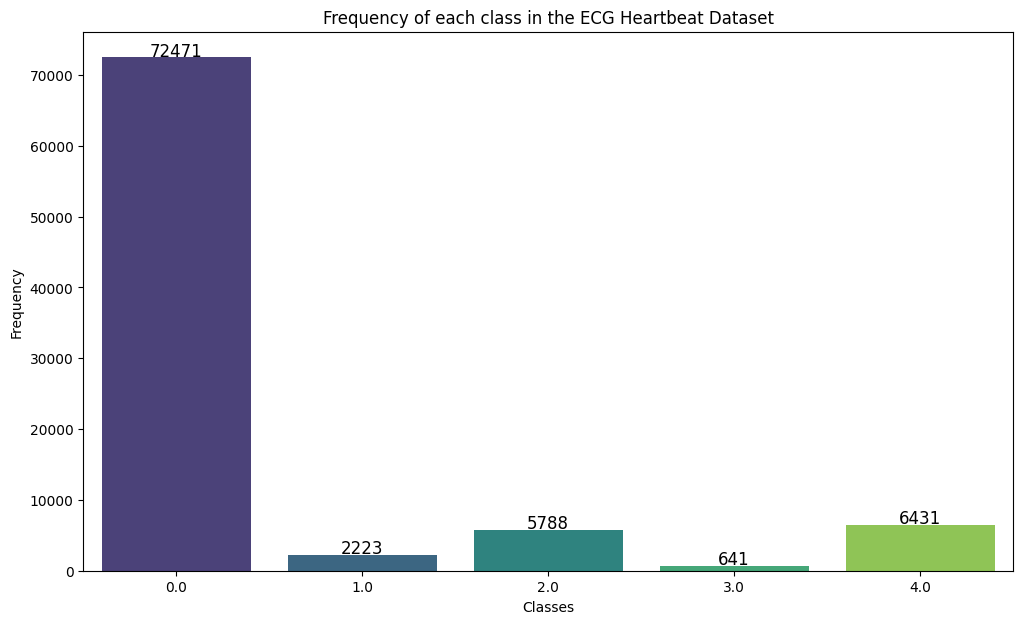

In [17]:
# Visualize classes
data_labels = df_train.iloc[:, -1]
class_counts = data_labels.value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 200, str(v), ha='center', fontsize=12)

plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Frequency of each class in the ECG Heartbeat Dataset")
plt.savefig("class_frequency.svg")
plt.show()


**highly imbalanced**

In [10]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values   # Labels

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape: {X_train_resampled.shape}, Labels shape: {y_train_resampled.shape}")

Resampled dataset shape: (362355, 187), Labels shape: (362355,)


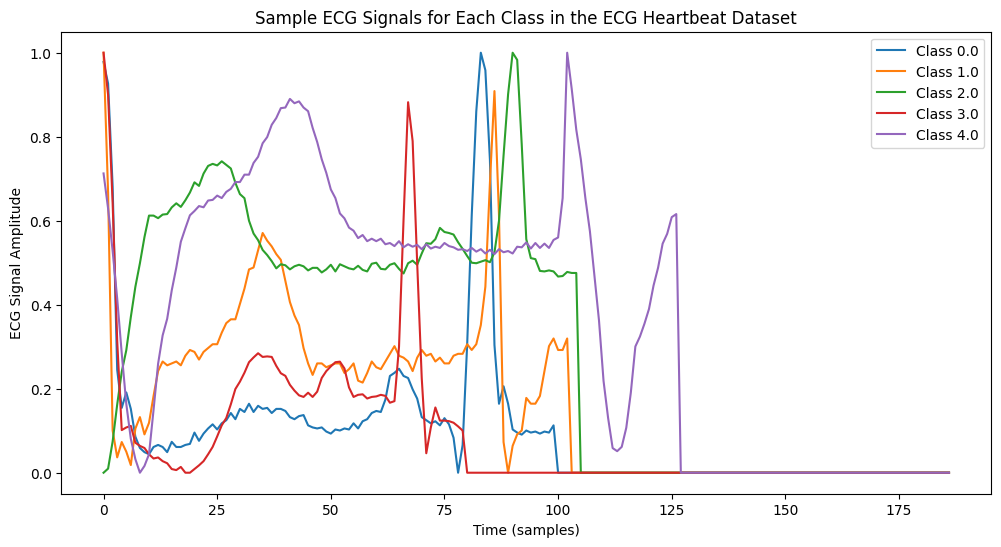

In [18]:
classes = np.unique(y_train)
class_samples = {}

# Extract one sample for each class
for cls in classes:
    class_samples[cls] = X_train[y_train == cls][0]  # First occurrence of each class

# Plot ECG signals for each class
plt.figure(figsize=(12, 6))

for cls, signal in class_samples.items():
    plt.plot(signal, label=f"Class {cls}")

plt.xlabel("Time (samples)")
plt.ylabel("ECG Signal Amplitude")
plt.title("Sample ECG Signals for Each Class in the ECG Heartbeat Dataset")
plt.legend()
plt.savefig("SampleECG.svg")
plt.show()

### Model

#### XGBoost

In [11]:
# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Normalize test data

# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, eval_metric="mlogloss", use_label_encoder=False)
eval_set = [(X_train_scaled, y_train_resampled), (X_test_scaled, y_test)]
xgb_model.fit(X_train_scaled, y_train_resampled,eval_set = eval_set,verbose = True)

# Get training history
evals_result = xgb_model.evals_result()

# Predict and evaluate on test dataset
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Test Accuracy: {xgb_accuracy * 100:.2f}%")
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.12403	validation_1-mlogloss:1.22117
[1]	validation_0-mlogloss:0.87070	validation_1-mlogloss:1.00113
[2]	validation_0-mlogloss:0.69810	validation_1-mlogloss:0.84914
[3]	validation_0-mlogloss:0.57375	validation_1-mlogloss:0.72976
[4]	validation_0-mlogloss:0.48271	validation_1-mlogloss:0.64338
[5]	validation_0-mlogloss:0.41501	validation_1-mlogloss:0.57654
[6]	validation_0-mlogloss:0.35950	validation_1-mlogloss:0.51950
[7]	validation_0-mlogloss:0.31794	validation_1-mlogloss:0.47823
[8]	validation_0-mlogloss:0.28411	validation_1-mlogloss:0.44518
[9]	validation_0-mlogloss:0.25731	validation_1-mlogloss:0.41639
[10]	validation_0-mlogloss:0.23671	validation_1-mlogloss:0.39619
[11]	validation_0-mlogloss:0.21700	validation_1-mlogloss:0.37287
[12]	validation_0-mlogloss:0.20157	validation_1-mlogloss:0.35559
[13]	validation_0-mlogloss:0.18957	validation_1-mlogloss:0.34122
[14]	validation_0-mlogloss:0.17666	validation_1-mlogloss:0.32443
[15]	validation_0-mlogloss:0.16677	

#### CNN

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for CNN
X_train_cnn = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert labels to categorical (one-hot encoding) for CNN
y_train_cnn = to_categorical(y_train_resampled, num_classes=5)
y_test_cnn = to_categorical(y_test, num_classes=5)

# Define CNN Model with Dropout
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting

    tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout before the final layer
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes
])

# Compile the model
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model with Early Stopping
results = cnn_model.fit(X_train_cnn, y_train_cnn,
                        epochs=20, batch_size=32,
                        validation_data=(X_test_cnn, y_test_cnn),
                        callbacks=[early_stop])

# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.7713 - loss: 0.6210 - val_accuracy: 0.8799 - val_loss: 0.3233
Epoch 2/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.9101 - loss: 0.2515 - val_accuracy: 0.9071 - val_loss: 0.2492
Epoch 3/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9338 - loss: 0.1890 - val_accuracy: 0.9311 - val_loss: 0.1960
Epoch 4/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9451 - loss: 0.1550 - val_accuracy: 0.9423 - val_loss: 0.1667
Epoch 5/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - accuracy: 0.9534 - loss: 0.1339 - val_accuracy: 0.9430 - val_loss: 0.1609
Epoch 6/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9592 - loss: 0.1172 - val_accuracy: 0.9554 - val_loss: 0.1379
Epoch 7/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9635 - loss: 0.1057 - val_accuracy: 0.9614 - val_loss: 0.1254
Epoch 8/20
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 

#### Compare

In [13]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

print(f"XGBoost Accuracy: {xgb_accuracy * 100:.2f}%")
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.57      0.84      0.68       556
         2.0       0.93      0.95      0.94      1448
         3.0       0.60      0.87      0.71       162
         4.0       0.98      0.99      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.81      0.92      0.86     21892
weighted avg       0.97      0.97      0.97     21892

XGBoost Accuracy: 96.84%
CNN Accuracy: 96.72%


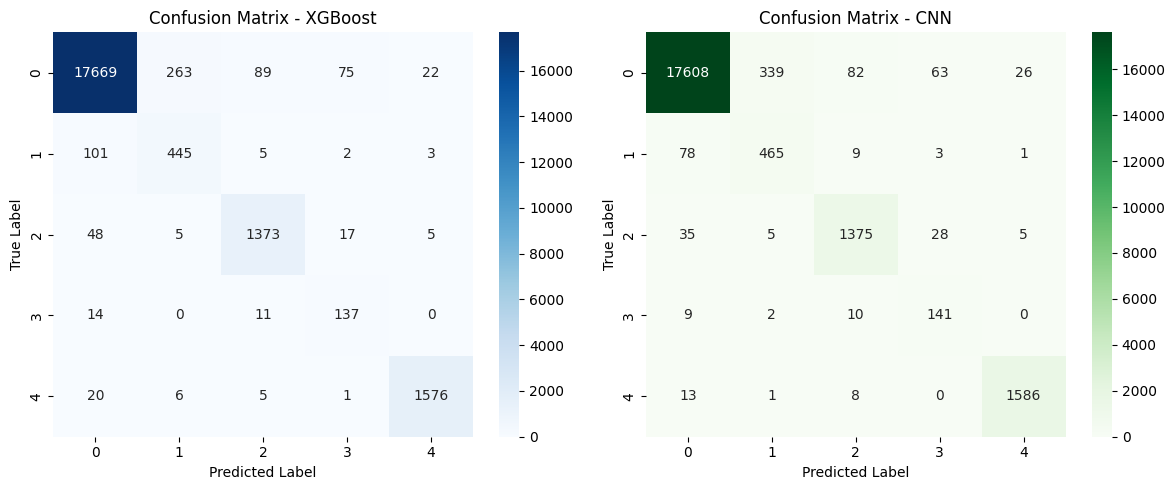

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices for XGBoost and CNN
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix for XGBoost
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")

# Plot confusion matrix for CNN
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN")

# Show plots
plt.tight_layout()
plt.savefig("comparison.svg")
plt.show()

#### Others

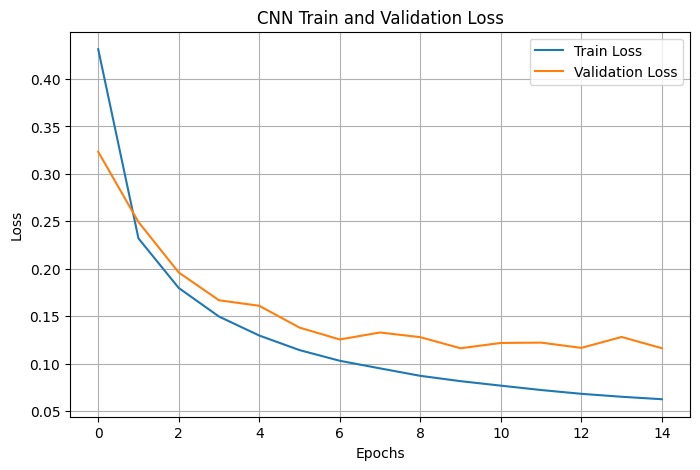

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("CNN_Loss.svg")
plt.show()


XgBoost


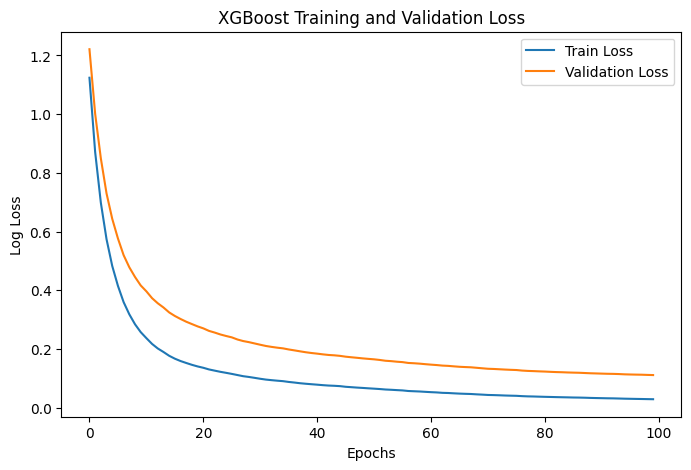

In [16]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(evals_result['validation_0']['mlogloss'], label='Train Loss')
plt.plot(evals_result['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("XGBoost_Loss.svg")
plt.show()